# Generating Weekday and Weekend profiles

In [154]:
import polars as pl
import glob
import re
from pathlib import Path
import os
from datetime import datetime
from pathlib import Path
import polars as pl
import re
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
from datetime import date, datetime
from datetime import timedelta
from tslearn.clustering import TimeSeriesKMeans 

logging.getLogger('matplotlib.font_manager').disabled = True

from validation import validation

from kmodes.kprototypes import KPrototypes

import pandas as pd

In [155]:
pattern = f"{r'DATA/SM_DATA_average_min'}/*CH*.csv"
file_paths = glob.glob(pattern)

In [156]:
n_timestamps = 96

data_list = []

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)

data_3d = np.concatenate(data_list, axis=0)
print(f"Shape of the 3D array: {data_3d.shape}")

n_samples = data_3d.shape[0]




Shape of the 3D array: (1464, 96, 1)


In [157]:
# Read the Excel file

# missing vlaues are encoded as -1

file_path = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/Survey_Data/Survey_Data.xlsx"

# 1. Read the survey data
survey_df = pd.read_excel(file_path, skiprows=4, nrows=n_samples, header=None)

# Columns to extract as survey features: heat pump, EV, electrical heating of hot water
cols_to_extract = [144, 145, 146, 131]

# First, create the categorical objects for each survey column
cat1 = survey_df.iloc[:, cols_to_extract[0]].astype('category')
cat2 = survey_df.iloc[:, cols_to_extract[1]].astype('category')
cat3 = survey_df.iloc[:, cols_to_extract[2]].astype('category')
cat4 = survey_df.iloc[:, cols_to_extract[3]].astype('category')

# You already have the integer codes stored in these arrays:
survey_array1 = cat1.cat.codes.to_numpy()
survey_array2 = cat2.cat.codes.to_numpy()
survey_array3 = cat3.cat.codes.to_numpy()
survey_array4 = cat4.cat.codes.to_numpy()

# Number of samples and timestamps in your existing data_3d
n_samples, n_timestamps, n_features = data_3d.shape

# Check length consistency
assert len(survey_array1) == n_samples
assert len(survey_array2) == n_samples
assert len(survey_array3) == n_samples
assert len(survey_array4) == n_samples

# 2. Flatten the numeric time series part (assuming original consumption feature is index 0)
time_series_numeric = data_3d[:, :, 0].reshape(n_samples, n_timestamps)

# 3. Stack survey arrays to shape (n_samples, 3) as categorical features
survey_features = np.stack([survey_array1, survey_array2, survey_array3, survey_array4], axis=1)

# 4. Combine numeric + categorical features horizontally
combined_data = np.hstack([time_series_numeric, survey_features])

print(combined_data[:5, -4:])  # Print first 5 rows of the last 3 columns (survey features)




[[ 0.  0.  0.  2.]
 [ 0.  0.  0. -1.]
 [ 0.  0.  0.  2.]
 [ 0.  0.  1. -1.]
 [ 1.  0.  0.  2.]]


In [158]:

# combined_data shape: (n_samples, n_timestamps + 4)

# Create mask: True for rows with no -1 in the last 4 columns
valid_rows_mask = ~np.any(combined_data == -1, axis=1)

# Filter combined_data to keep only valid rows
combined_data_filtered = combined_data[valid_rows_mask]

print(f"Original number of samples: {combined_data.shape[0]}")
print(f"Filtered number of samples (no -1 in survey features): {combined_data_filtered.shape[0]}")

print(combined_data_filtered[:5, -4:])  # Check first 5 filtered rows for survey features

Original number of samples: 1464
Filtered number of samples (no -1 in survey features): 1253
[[0. 0. 0. 2.]
 [0. 0. 0. 2.]
 [1. 0. 0. 2.]
 [0. 0. 0. 2.]
 [0. 0. 0. 2.]]


In [159]:


# 5. Specify the categorical feature column indices (the last 3 columns)
categorical_indices = list(range(combined_data.shape[1] - 3, combined_data.shape[1]))

# 6. Initialize and run K-Prototypes clustering
kproto = KPrototypes(
    n_clusters=7, 
    init='Cao', 
    verbose=0, 
    max_iter=200, 
    gamma=0.5,
    random_state=42,
    n_init=10
)

clusters = kproto.fit_predict(combined_data, categorical=categorical_indices)

clusters = clusters + 1

print("Cluster labels:")
print(clusters)

Cluster labels:
[6 7 6 ... 5 5 3]


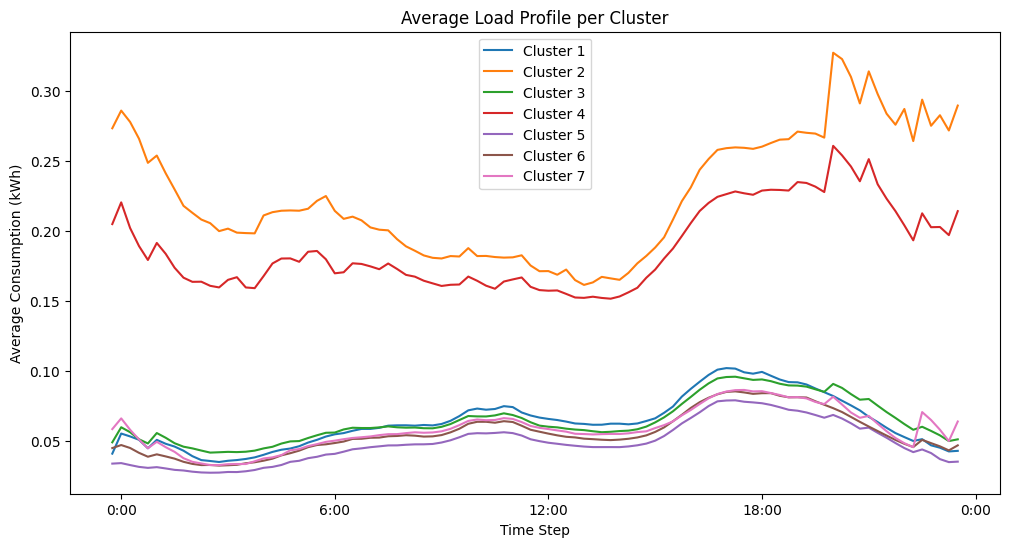

In [160]:
unique_clusters = np.unique(clusters)

labels = ['0:00','6:00','12:00','18:00','0:00']

plt.figure(figsize=(12, 6))
for cl in unique_clusters:
    idx = np.where(clusters == cl)[0]
    avg_profile = time_series_numeric[idx].mean(axis=0)
    plt.plot(avg_profile, label=f'Cluster {cl}')

plt.title('Average Load Profile per Cluster')
plt.xticks(range(1,120,24),labels=labels)
plt.xlabel('Time Step')
plt.ylabel('Average Consumption (kWh)')
plt.legend()
plt.show()



In [161]:
df = pd.DataFrame({
    'cluster': clusters,
    'HP': survey_array1,                  # 0/1 integer (e.g., "Has Heat Pump")
    'EV': survey_array2,                  # 0/1 integer (e.g., "Has EV")
    'Electric Water Heating': survey_array3,  # 0/1 integer
    'Tenant Type': survey_array4  
})

def decode_codes_with_na(codes, categories, na_label="NaN"):
    decoded = np.full(codes.shape, na_label, dtype=object)
    valid_mask = codes >= 0
    decoded[valid_mask] = categories[codes[valid_mask]]
    return decoded

# Example usage for Tenant Type
df['Tenant Type_decoded'] = decode_codes_with_na(df['Tenant Type'], cat4.cat.categories, na_label="NaN")

# Similarly decode others if needed
df['HP_decoded'] = decode_codes_with_na(df['HP'], cat1.cat.categories, na_label="NaN")
df['EV_decoded'] = decode_codes_with_na(df['EV'], cat2.cat.categories, na_label="NaN")
df['Electric Water Heating_decoded'] = decode_codes_with_na(df['Electric Water Heating'], cat3.cat.categories, na_label="NaN")

#print(df)




In [162]:
# Columns to check for 'NaN' string
decoded_cols = ['HP_decoded', 'EV_decoded', 'Electric Water Heating_decoded', 'Tenant Type_decoded']

# Filter out rows where any decoded column has 'NaN'
df_cleaned = df[~df[decoded_cols].isin(['NaN']).any(axis=1)]

#print(df_cleaned)

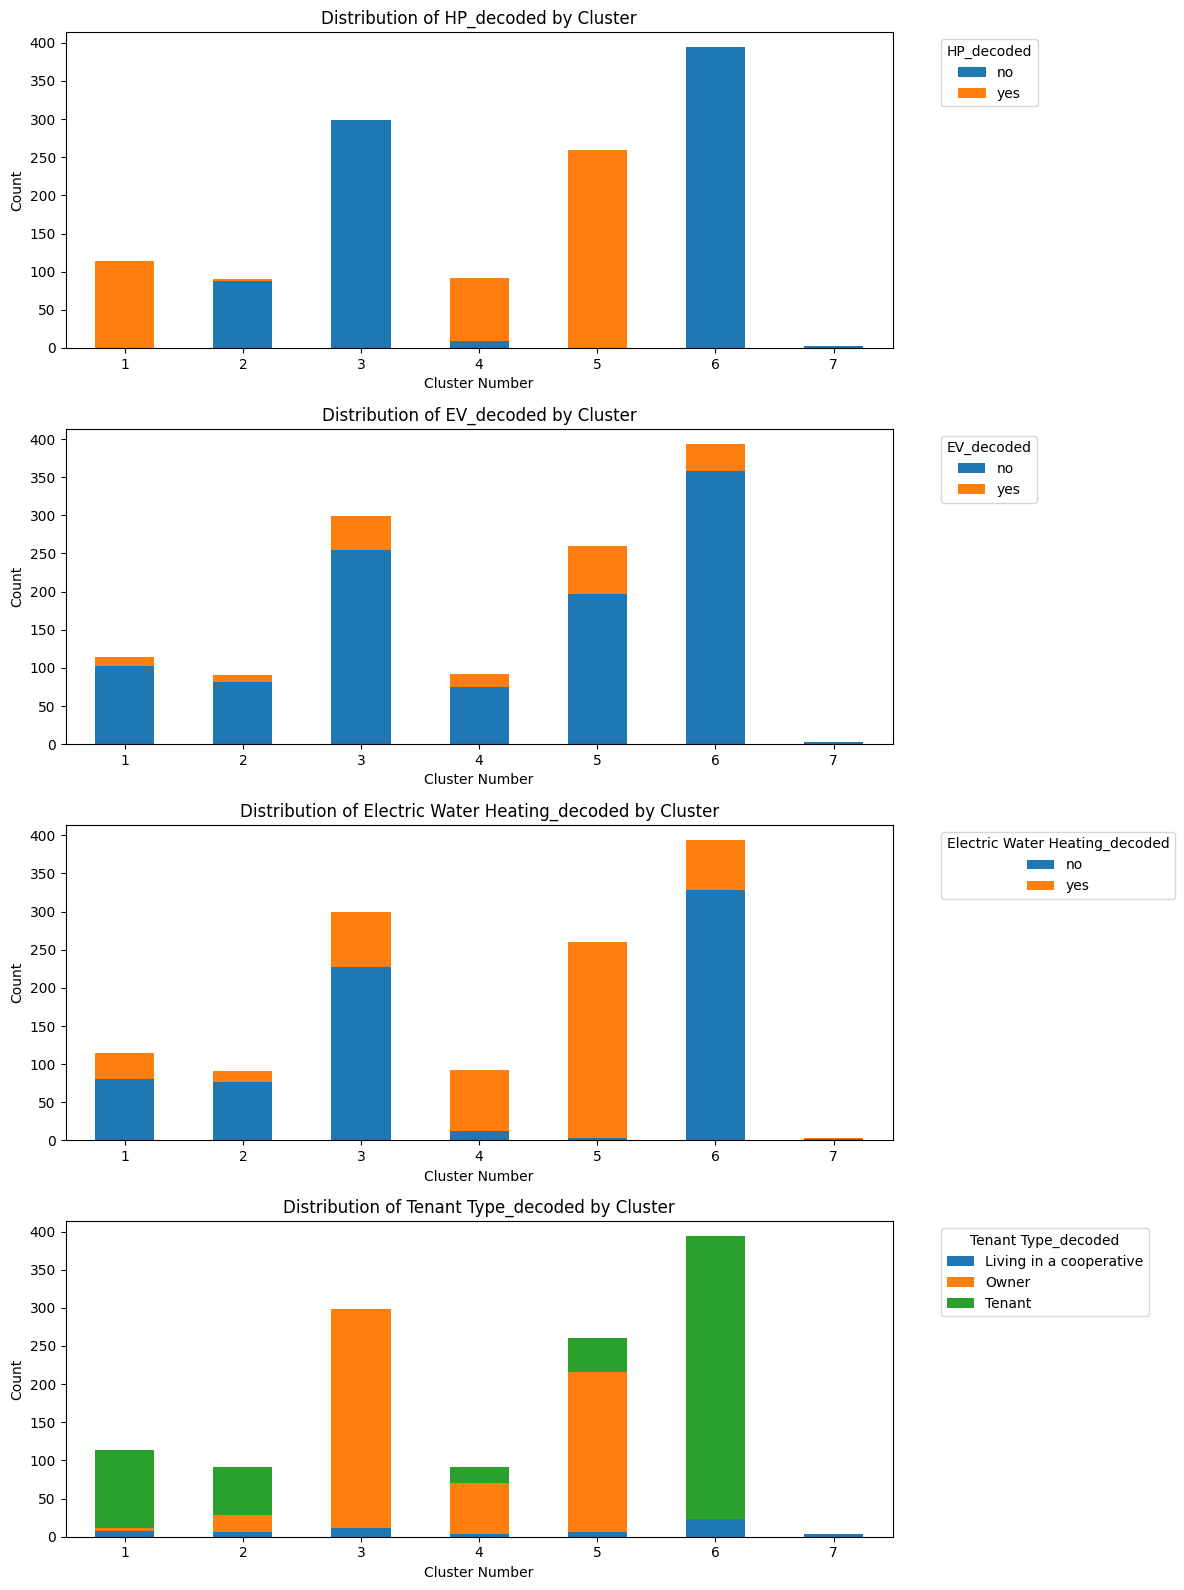

In [163]:
cat_columns = ['HP_decoded', 'EV_decoded', 'Electric Water Heating_decoded', 'Tenant Type_decoded']
n_features = len(cat_columns)

fig, axes = plt.subplots(n_features, 1, figsize=(12, 4 * n_features))

for i, feature in enumerate(cat_columns):
    ax = axes[i]
    
    # Group and pivot data for the plot
    counts = df_cleaned.groupby(['cluster', feature]).size().unstack(fill_value=0)
    
    # Plot stacked bar chart
    counts.plot(kind='bar', stacked=True, ax=ax)
    
    # Titles and axis labels
    ax.set_title(f'Distribution of {feature} by Cluster')
    ax.set_ylabel('Count')
    ax.set_xlabel('Cluster Number')
    
    # Rotate x-axis tick labels by 90 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-0)
    ax.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()





In [164]:
features = ['HP_decoded', 'EV_decoded', 'Electric Water Heating_decoded', 'Tenant Type_decoded']
dfs = []

for feature in features:
    counts = df_cleaned.groupby(['cluster', feature]).size().unstack(fill_value=0)

    fractions = counts.div(counts.sum(axis=1), axis=0)
    
    # Rename cluster index to string with 'Cluster ' prefix
    fractions.index = [f'Cluster {c}' for c in fractions.index]
    
    # Use MultiIndex for rows: (feature, category)
    row_idx = pd.MultiIndex.from_product([[feature], fractions.columns], names=['Feature', 'Category'])
    
    # Transpose to have clusters as columns
    fractions = fractions.T
    
    # Assign MultiIndex rows
    fractions.index = row_idx
    
    dfs.append(fractions)

final_table = pd.concat(dfs)

#print(final_table)
display(final_table.style.format("{:.2%}"))



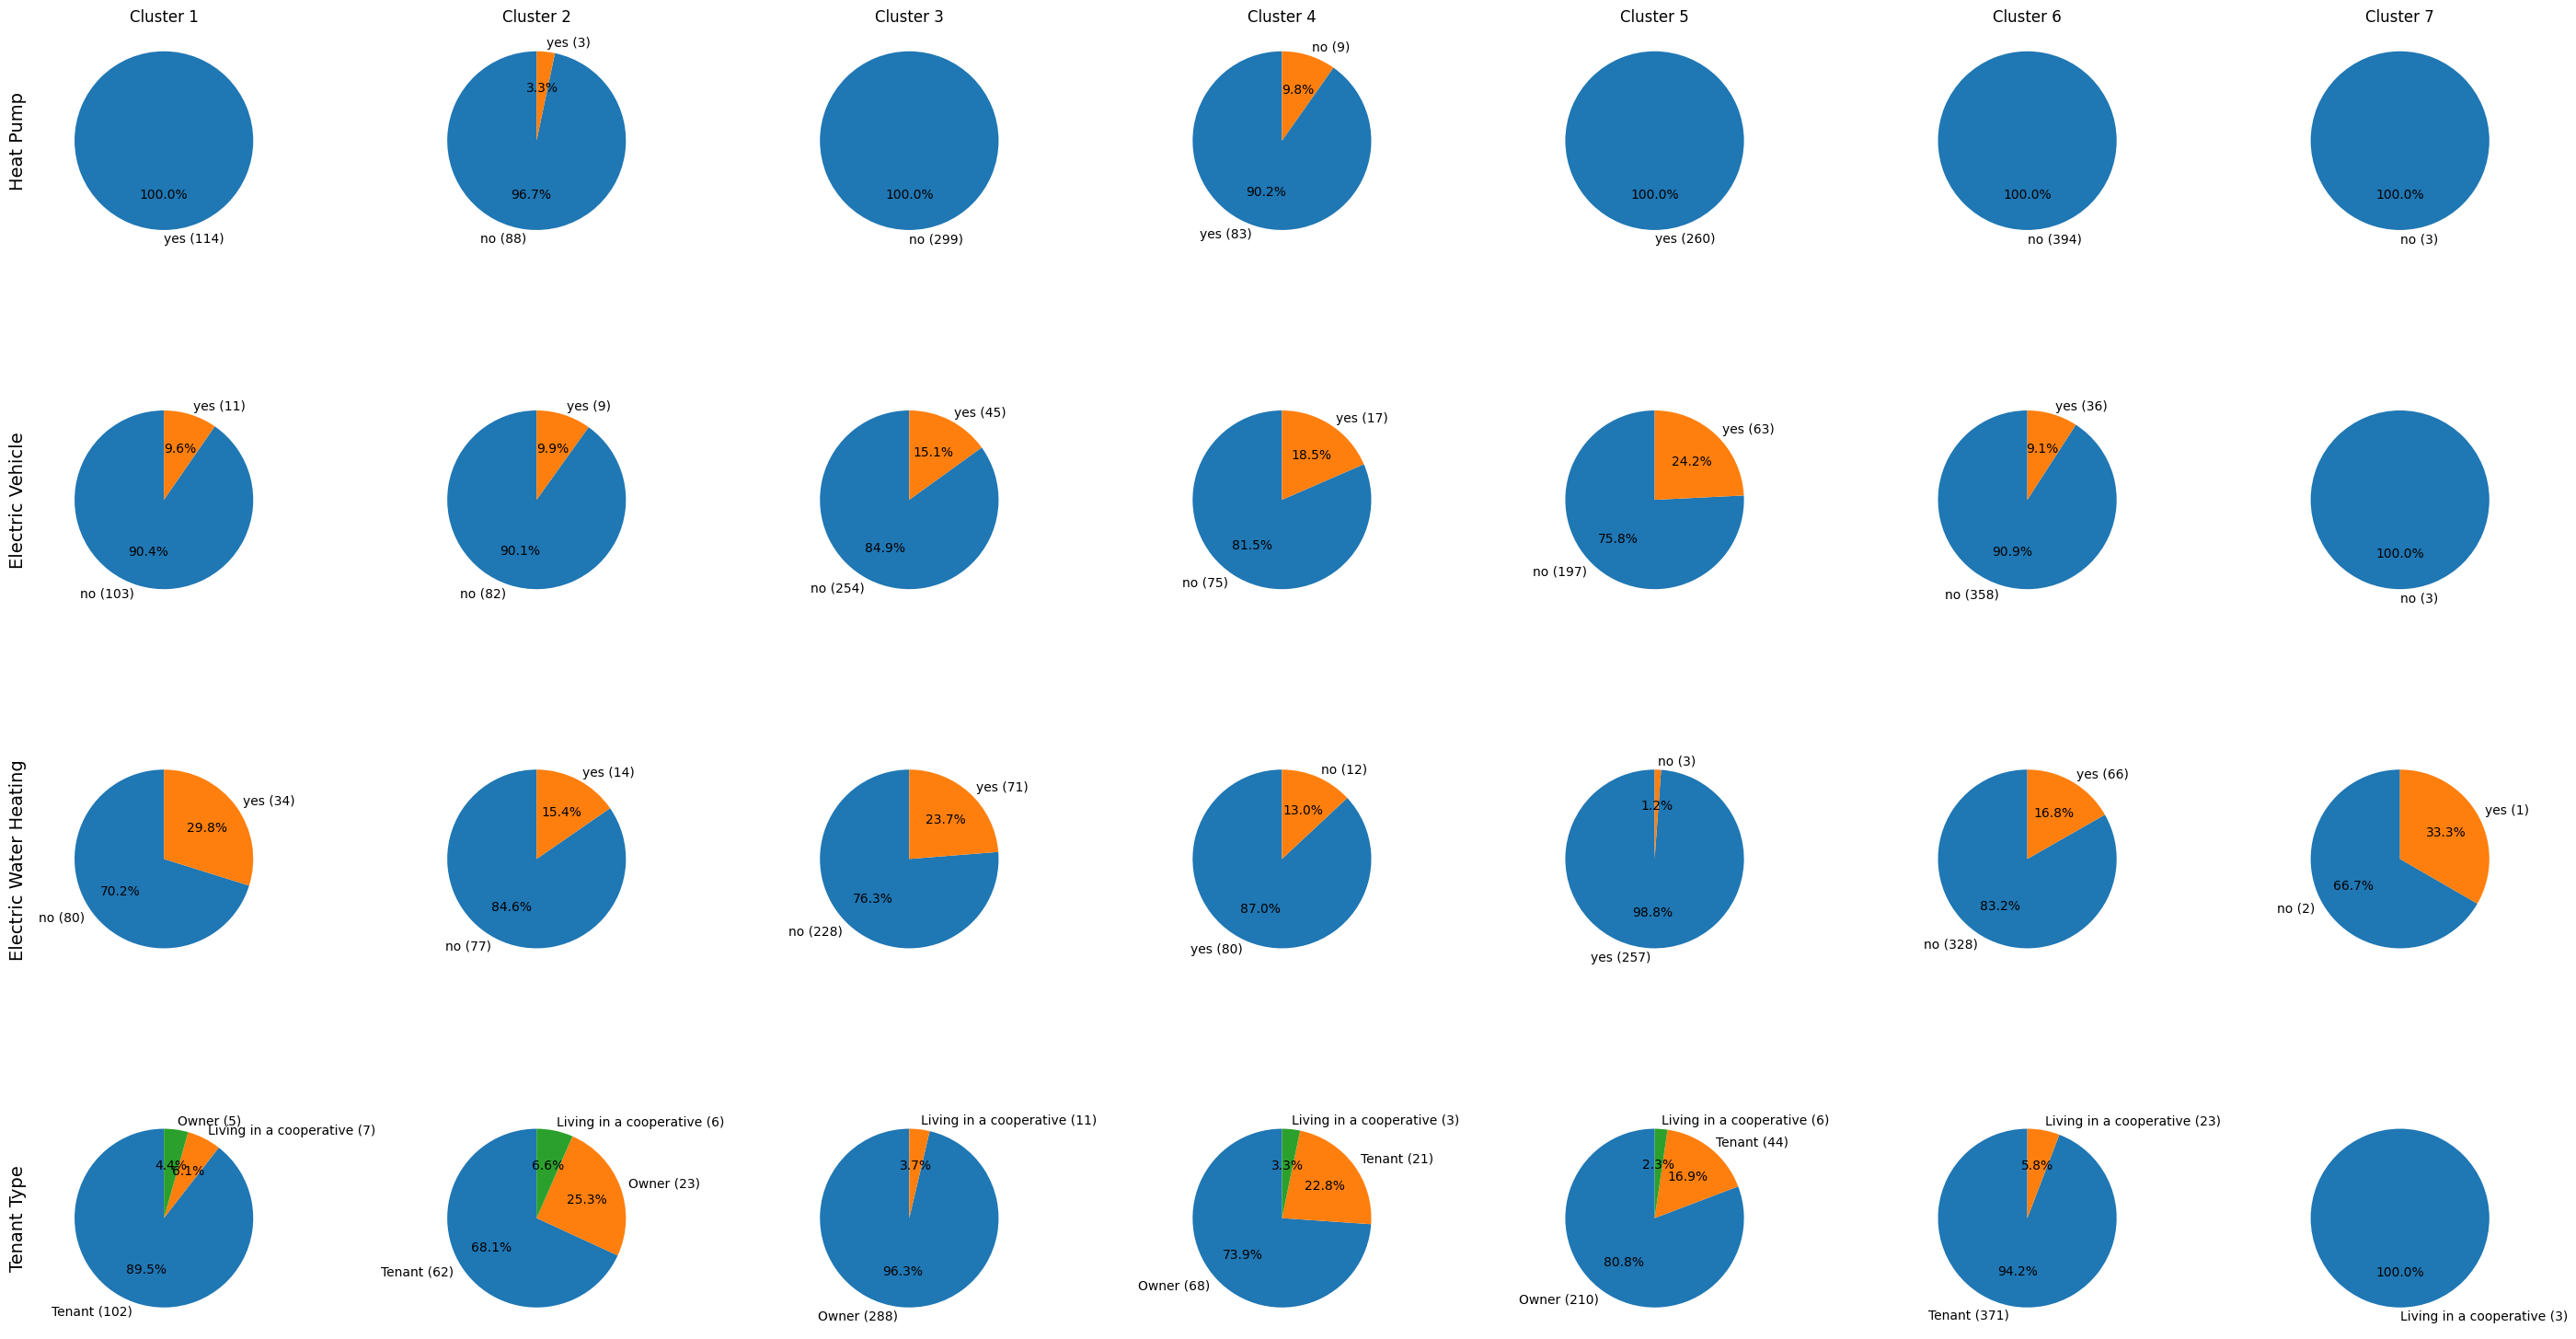

In [165]:
features = ['HP_decoded', 'EV_decoded', 'Electric Water Heating_decoded', 'Tenant Type_decoded']

feature_label = ['Heat Pump', 'Electric Vehicle', 'Electric Water Heating', 'Tenant Type']

# Get list of unique clusters sorted
clusters_sorted = sorted(df_cleaned['cluster'].unique())

n_features = len(features)
n_clusters = len(clusters_sorted)

fig, axes = plt.subplots(n_features, n_clusters, figsize=(4*n_clusters, 4*n_features))

for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters_sorted):

        ax = axes[i, j] if n_features > 1 else axes[j]

        data = df_cleaned[(df_cleaned['cluster'] == cluster) & (df_cleaned[feature].notna())][feature]

        counts = data.value_counts()
        
        # Create labels including category name and count
        labels = [f"{cat} ({count})" for cat, count in zip(counts.index, counts.values)]
        
        ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
        
        if i == 0:
            ax.set_title(f'Cluster {cluster}')
        if j == 0:
            ax.set_ylabel(feature_label[i], fontsize=14, labelpad=20)

plt.tight_layout()
plt.show()